# Table of contents
1. [Introduction](#introduction)
2. [Data load and presentation](#presentation)
3. [Shallow classifier](#shallow)
    1. [HoG features](#hog)
    2. [Fitting linear SVM](#svm)
4. [Transfer learning approach](#transfer)
5. [Visualize data with dimensionality reduction](#visualize)
    1. [PCA](#pca)
    2. [UMAP](#umap)

### Introduction <a name="introduction"></a>

CIFAR-10 data set is commonly used in machine learning tasks as a baseline for results of newly introduced algorithms[1]. It consists of 60,000 32x32 images with 10 label classes. It is balanced data set, with 6,000 representants of each class[2]. In case of this task there are 6 batches with 10,000 examples chosen randomly from uniform distribution. 5 of these batches are marked as training set and one of them as a test set. The goal of this assignment is to classify images from test set with algorithm trained on training set.

[1] https://www.kaggle.com/benhamner/popular-datasets-over-time/code
<br>
[2] https://www.cs.toronto.edu/~kriz/cifar.html

In [4]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import seaborn as sns
from umap import UMAP
from collections import defaultdict
import pickle
import time
from functools import wraps
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


from ddrop import DropConnect
from utils import unpickle, load_cifar_data, data_generator, resize_images, Timer, download, timeit
from visual_utils import plot_images, plot_pca_results, plot_umap_results

We will set custom figure size for all plots

In [0]:
plt.rcParams['figure.figsize'] = (10, 10)

### Data load and presentation <a name="presentation"></a>

Loading dataset using custom function

In [0]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, label_names = load_cifar_data()

In [0]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 32, 32, 3)
(40000,)
(10000, 32, 32, 3)
(10000,)
(10000, 32, 32, 3)
(10000,)


Plot images with one category for each row

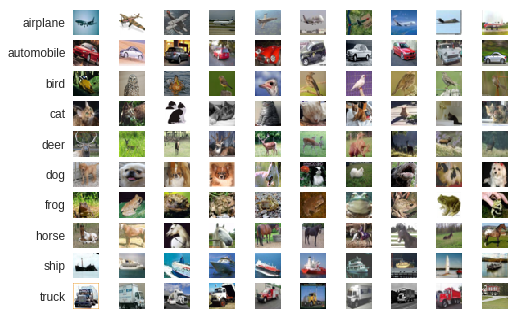

In [0]:
random.seed(42)
plot_images(X_train, Y_train, label_names)

### HoG features <a name='hog'></a>

Histogram of oriented gradients is a common method to extract features from images. The algorithm counts occurences of gradient orientation in a given part of an image. In this task we applied function to calculate HoG features, based on OpenCV implementation, which applies sobel mask on an image and then calculates histogram of gradient's orientations derived from processed input.

In [0]:
def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bin_n = 16 # Number of bins
    bins = np.int32(bin_n*ang/(2*np.pi))

    bin_cells = []
    mag_cells = []

    cellx = celly = 8

    for i in range(0, int(img.shape[0]/celly)):
        for j in range(0, int(img.shape[1]/cellx)):
            bin_cells.append(bins[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])
            mag_cells.append(mag[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])   

    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)

    # transform to Hellinger kernel
    eps = 1e-7
    hist /= hist.sum() + eps
    hist = np.sqrt(hist)
    hist /= np.linalg.norm(hist) + eps
    return hist

Create new variable to map labels to HoG features

In [0]:
hog_train = np.asarray([hog(array) for array in X_train])
hog_test = np.asarray([hog(array) for array in X_test])

### Fitting linear SVM on top of HoG features <a name='svm'></a>

Firstly we are going to use SVM with linear kernel to use it as our shallow classifier. Since we have 256 features extracted from histogram of gradients and 40,000 examples in training set we are going to use LinearSVC class from scikit-learn package, which is based on liblinear library and therefore scsales linearly with number of inputs and its features.

In [5]:
@timeit
def linear_svm(X_train, Y_train, X_val, Y_val, c=1e-4):
    clf = LinearSVC(C=c)
    clf.fit(X_train, Y_train)
    predictions_train = clf.predict(X_train)
    accuracy_train = accuracy_score(predictions_train, Y_train)
    predictions_val = clf.predict(X_val)
    accuracy_val = accuracy_score(predictions_val, Y_val)
    print(f"Accuracy on train: {accuracy_train} \n Accuracy on validation: {accuracy_val}")
    return accuracy_val

In [6]:
linear_svm(hog_train, Y_train, hog_val, Y_val)

NameError: name 'hog_train' is not defined

The baseline accuracy for our algorithm is **0.5342** on test set. It is already much better than random guessing since
it would have given result of about 0.10 due to the fact that we have balanced data with 10 classes.

### Transfer learning approach <a name="transfer"></a>

We are going to move to transfer learning approach with pretrained on ImageNet dataset ResNet50, which can be found in Keras library, as our source of weights.
<br>
We chose Keras version 2.1.6 in order to lower number of features which are extracted after flattening the output from pretrained layers, since the AveragePooling layer in later versions of Keras changed its shape which results in change much larger number of features extracted:
<br>
https://github.com/keras-team/keras/issues/10469
<br>
Transfer learning will consist of following parts:
* Extracting the features using ResNet50
* Visualize output using dimensionality reduction techniques (PCA and UMAP)
* Adding layers on top of pretrained neural network to add regularisation
* Playing with features extracted from UMAP to see if there is possibility to use another classifier (note that we shouldn't do something like that with t-SNE extracted features, which will be explained further)

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocessor
from keras.layers import Reshape, Dense, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.utils import shuffle

In [ ]:
def resnet_base_flatten():
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224,3))
    out = Reshape((2048,))(model.out)
    return Model(model.input, out)

During data generation part we are going to transform images to fit ResNet architecture (with target shape being (224, 224, 3)).

In [0]:
model = resnet_base_flatten()

batch_size = 40
codes_train = model.predict_generator(data_generator(X_train, Y_train, batch_size=batch_size), 
                                           X_train.shape[0]/batch_size, verbose=1)
codes_val = model.predict_generator(data_generator(X_val, Y_val, batch_size=batch_size), 
                                         X_val.shape[0] / batch_size, verbose=1)
codes_test = model.predict_generator(data_generator(X_test, Y_test, batch_size=batch_size), 
        X_test.shape[0]/ batch_size, verbose=1)

In [0]:
np.save('codes_train.npy', codes_train) 
np.save('codes_val.npy', codes_val)
np.save('codes_test.npy', codes_test)

In [0]:
codes_train = np.load('/content/drive/My Drive/cifar-10-batches-py/codes_train.npy')
codes_val = np.load('/content/drive/My Drive/cifar-10-batches-py/codes_val.npy')
codes_test = np.load('/content/drive/My Drive/cifar-10-batches-py/codes_test.npy')

### Visualize data with dimensionality reduction <a name="visualize"></a>

### PCA <a name='pca'></a>
We will take first two PCA components to visualize pretrained CNN codes.

Text(0.5, 1.0, 'PCA decomposition')

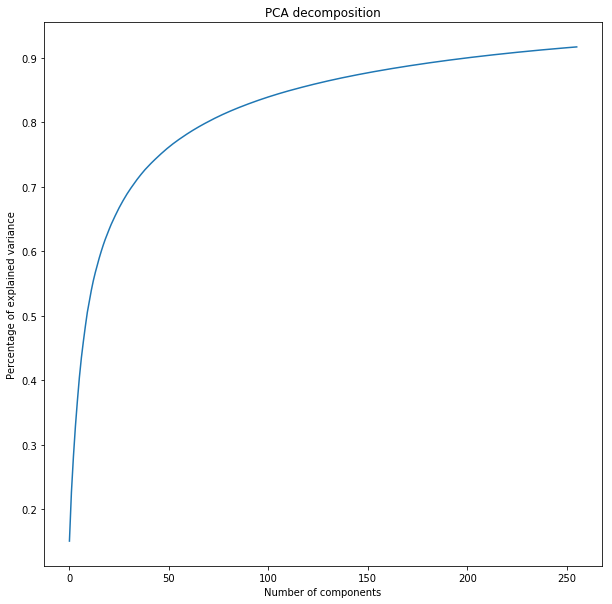

In [0]:
pca = PCA(n_components=256)

components = pca.fit_transform(codes_train)

We can observe that first two components of PCA will explain small amount of variance in our data, so we don't
expect the plot to be very informative

In [0]:
components_first_two=components[:, :2]
plot_pca_results(components_first_two, Y_train, label_names, "Dimensionality reduction with PCA")

However it is possible to observe first trend in our results - animals are closer to each other than trucks
and airplaines, so it can be seen that we can already have some meaningful interpretation of this visualisation.

### UMAP <a name='umap'></a>

UMAP is non-linear dimensionality reduction technique which has some advantages over commonly used t-SNE algorithm.
<br>
As written in original paper:
<br>
"(...) UMAP has significantly more stable results than t-SNE. In particular, after sub-sampling on 5% of
the million data points, the per point error for UMAP was already below any
value achieved by t-SNE."[1]
<br>
It has been already tested in many different cases, for example on biological data:
<br>
"(...) UMAP seems to yield representation that are
as meaningful as t-SNE does, particularly in its ability resolve even subtly differing cell
populations. In addition, it provides the useful and intuitively pleasing feature that it
preserves more of the global structure (...)"[2]

[1] https://arxiv.org/pdf/1802.03426.pdf
<br>
[2] https://www.biorxiv.org/content/biorxiv/early/2018/04/10/298430.full.pdf

In [0]:
with Timer():
    neighbors = [100, 200, 300]
    umaps = [UMAP(n_components=2, n_neighbors=number, random_state=42) for number in neighbors]
    umap_features = [umap.fit_transform(codes_train) for umap in umaps]

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=100, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connect

Plot result for different number of neighbors

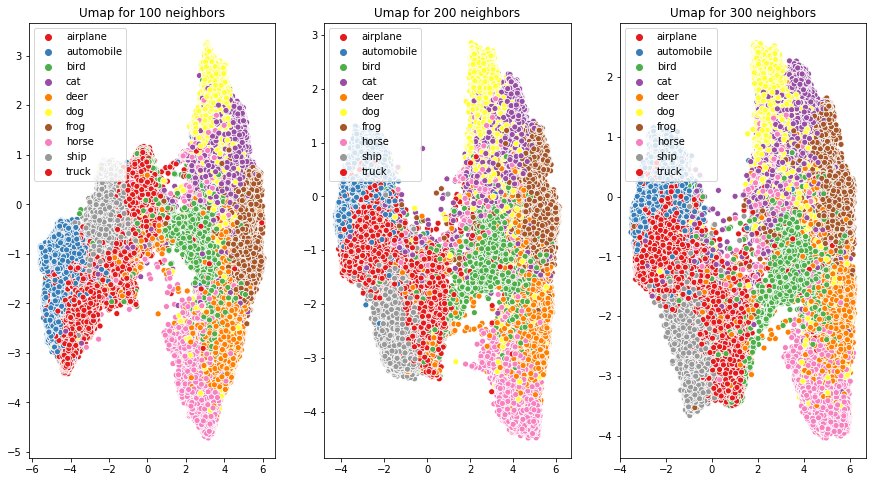

In [0]:
plot_umap_results(umap_features, neighbors, Y_train, label_names)

Fitting linear SVM

Grid search over parameter C (penalty parameter of the error term)

In [0]:
best = 0
for c in [1e-2, 1e-3, 5e-3, 1e-4]:
    print(f"Fitting for C value of {c}")
    result = linear_svm(codes_train, Y_train, codes_val, Y_val, c=c)
    if result > best:
        best = result

Fitting for C value of 0.01
Accuracy on train: 0.970525 
 Accuracy on validation: 0.9111
Fitting for C value of 0.05


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy on train: 0.983825 
 Accuracy on validation: 0.9021
Fitting for C value of 0.001
Accuracy on train: 0.944775 
 Accuracy on validation: 0.9161
Fitting for C value of 0.005
Accuracy on train: 0.96365 
 Accuracy on validation: 0.9137
Fitting for C value of 0.0001
Accuracy on train: 0.9147 
 Accuracy on validation: 0.903


Best obtained accuracy was 0.9161 for 

Trying with non-linear version of kernel

In [0]:
@timeit
def svm_non_linear(X_train, Y_train, X_val, Y_val, C=1e-4, kernel='rbf'):
    clf = SVC(C, kernel=kernel, gamma='scale')
    clf.fit(X_train, Y_train)
    predictions_train = clf.predict(X_train)
    accuracy_train = accuracy_score(predictions_train, Y_train)
    predictions_val = clf.predict(X_val)
    accuracy_val = accuracy_score(predictions_val, Y_val)
    print(f"Accuracy on train: {accuracy_train} \n Accuracy on validation: {accuracy_val}")

In [0]:
svm_non_linear(codes_train, Y_train, codes_val, Y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The code did not compile until the end of the session - we can either stick to linear svm and investigate different results with changed neural network or use dimensionality reduction and train more advenced classifier then

### Fine tuning of CNN

After extracting features from pretrained ResNet, we can add another layers on top of it to classify our images.
Our first approach will include adding dense layer with relu type activation and Dropout before it to regularize our network.

In [0]:
def resnet_with_dropout(hidden_units=2048, drop_rate=0.5, input_shape=(2048, )):
    model = Sequential()
    model.add(Dropout(drop_rate, input_shape=input_shape))
    model.add(Dense(hidden_units, activation='relu', input_shape=input_shape))
    model.add(Dense(10, activation='softmax'))
    return model

In [0]:
model_dropout = resnet_with_dropout()
model_dropout.compile(optimizer = Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
batch_size = 32
model_dropout.fit(codes_train, Y_train, batch_size=batch_size, epochs=100,
                  validation_data=(codes_val, Y_val),
                  callbacks=[ModelCheckpoint('dropout_05.h5', monitor='val_acc', save_best_only=True)])

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 12s 297us/step - loss: 0.5071 - acc: 0.8273 - val_loss: 0.3226 - val_acc: 0.8893
Epoch 2/100
40000/40000 [==============================] - 9s 224us/step - loss: 0.3863 - acc: 0.8646 - val_loss: 0.3079 - val_acc: 0.8944
Epoch 3/100
40000/40000 [==============================] - 9s 222us/step - loss: 0.3441 - acc: 0.8797 - val_loss: 0.2900 - val_acc: 0.9022
Epoch 4/100
40000/40000 [==============================] - 9s 223us/step - loss: 0.3188 - acc: 0.8879 - val_loss: 0.3021 - val_acc: 0.8971
Epoch 5/100
40000/40000 [==============================] - 9s 223us/step - loss: 0.3009 - acc: 0.8933 - val_loss: 0.2823 - val_acc: 0.9035
Epoch 6/100
40000/40000 [==============================] - 9s 224us/step - loss: 0.2801 - acc: 0.9008 - val_loss: 0.2715 - val_acc: 0.9066
Epoch 7/100
40000/40000 [==============================] - 9s 224us

There is also an alternative approach to regularize neural networks which is called DropConnect. DropConnect is a regularisation technique which was introduced as an alternative approach to dropout[1].
As written in a paper: "When training with Dropout,
a randomly selected subset of activations are
set to zero within each layer. DropConnect instead sets a randomly selected subset of weights within the network to zero." One can think of DropConnect as a Dropout generalization to the fully connected layers.

<figure class="image">
  <img src="dropconnect.png" alt="dropconnect"></img>
  <figcaption><center> Comparison of neural network architectures taken from [2].</center></figcaption>
</figure>

[1] http://proceedings.mlr.press/v28/wan13.pdf
<br>
[2] https://cs.nyu.edu/~wanli/dropc/

In [0]:
def resnet_with_dropconnect(hidden_units=2048, drop_rate=0.5, input_shape=(2048, )):
    model = Sequential()
    model.add(DropConnect(Dense(hidden_units, activation='relu'), prob=0.5,input_shape=input_shape))
    model.add(Dense(10, activation='softmax'))
    return model

In [0]:
model_dropconnect = resnet_with_dropconnect()
model_dropconnect.compile(optimizer = Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
batch_size = 32
model_dropconnect.fit(codes_train, Y_train, batch_size=batch_size, epochs=100,
                  validation_data=(codes_val, Y_val),
                  callbacks=[ModelCheckpoint('dropconnect_05.h5', monitor='val_acc', save_best_only=True)])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 11s 272us/step - loss: 0.4367 - acc: 0.8520 - val_loss: 0.3073 - val_acc: 0.8956
Epoch 2/100
40000/40000 [==============================] - 10s 253us/step - loss: 0.3037 - acc: 0.8943 - val_loss: 0.2932 - val_acc: 0.8994
Epoch 3/100
40000/40000 [==============================] - 10s 254us/step - loss: 0.2664 - acc: 0.9086 - val_loss: 0.3180 - val_acc: 0.8913
Epoch 4/100
40000/40000 [==============================] - 10s 252us/step - loss: 0.2441 - acc: 0.9147 - val_loss: 0.2963 - val_acc: 0.9007
Epoch 5/100
40000/40000 [==============================] - 10s 252us/step - loss: 0.2236 - acc: 0.9211 - val_loss: 0.2815 - val_acc: 0.9035
Epoch 6/100
40000/40000 [==============================] - 10s 252us/step - loss: 0.2067 - acc: 0.9269 - val_loss: 0.2941 - val_acc: 0.9084
Epoch 7/100
40000/40000 [==============================] - 10s 251us/step - loss: 0.1914 - acc: 0.9328 - val_l

Result of best model with dropout:

In [15]:
best_dropout = load_model('/content/drive/My Drive/cifar-10-batches-py/dropout_05.h5')
best_dropout.evaluate(codes_test, Y_test)

SyntaxError: ignored

Result of best model with dropconnect:

In [14]:
best_dropconnect = load_model('/content/drive/My Drive/cifar-10-batches-py/dropconnect_05.h5', custom_objects={'DropConnect': DropConnect})
best_dropconnect.evaluate(codes_test, Y_test)

10000/10000 [==============================] - 1s 79us/step


[0.9892541858010718, 0.9167]

We achieved accuracy for neural network with DropConnect with **0.9167** for test set, which is our best result yet.

Another approach will be based on dimensionality reduction as used for data visualisation, but with larger number of components. It is worth to point out that t-SNE dimensionality reduction should not be used in such task:

https://stats.stackexchange.com/questions/340175/why-is-t-sne-not-used-as-a-dimensionality-reduction-technique-for-clustering-or

We are going to use umap for this task as it can learn the transformation and apply it afterwards to test set. 

Number of neighbors was based on the fac that during training we encountered warning mentioned in this github issue:

https://github.com/lmcinnes/umap/issues/90

As a possible solution it is advised to change number of neighbors used to train to an order of magnitude of hundreds.

In [0]:
codes_train_val = np.concatenate([codes_train, codes_val])
Y_train_val = np.concatenate([Y_train, Y_val])

In [13]:
# Transformation with UMAP followed by classification with a linear SVM
umap = UMAP(random_state=42, n_neighbors=100, n_components=50, verbose=True)
umap_50_features = umap.fit(codes_train_val)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=50, n_epochs=None,
   n_neighbors=100, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


TypeError: ignored

In [0]:
pickle.dump(umap_50_features, open("umap_50_features.pickle", 'wb'))

Fitting linear SVM on top of extracted features

In [0]:
codes_umap_50_features = umap_50_features.transform(codes_train_val)

In [16]:
codes_umap_50_features_test = umap_50_features.transform(codes_test)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [18]:
linear_svm(codes_umap_50_features, Y_train_val, codes_umap_50_features_test, Y_test, c=1e-3)

Accuracy on train: 0.78858 
 Accuracy on validation: 0.7617
Elapsed computation time: 1.765 secs


(1.764801263809204, 0.7617)

UMAP for several number of components has been fitted, however almost no change has been observed for number of components bigger than 50.

In [26]:
svm_non_linear(codes_umap_50_features, Y_train_val, codes_umap_50_features_test, Y_test)

Accuracy on train: 0.74726 
 Accuracy on validation: 0.7247
Elapsed computation time: 825.695 secs


(825.694803237915, None)

Trying with xgboost

In [0]:
@timeit
def xgb_sk(X_train, Y_train, X_val, Y_val):
    clf = xgb.XGBClassifier()
    clf.fit(X_train, Y_train)
    predictions_train = clf.predict(X_train)
    accuracy_train = accuracy_score(predictions_train, Y_train)
    predictions_val = clf.predict(X_val)
    accuracy_val = accuracy_score(predictions_val, Y_val)
    print(f"Accuracy on train: {accuracy_train} \n Accuracy on validation: {accuracy_val}")
    return accuracy_val

In [39]:
xgb_sk(codes_umap_50_features, Y_train_val, codes_umap_50_features_test, Y_test)

Accuracy on train: 0.84948 
 Accuracy on validation: 0.8153
Elapsed computation time: 284.107 secs


(284.1073760986328, 0.8153)

Ok, so it's not so bad - we can try some hyperparameter tuning then to see where we can go with this

In [0]:
np.random.seed(42)

def objective(space):
    clf = XGBClassifier(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'])

    eval_set  = [(codes_train, Y_train), (codes_val, Y_val)]

    clf.fit(codes_train, Y_train,
            eval_set=eval_set, eval_metric="merror",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(codes_val)
    accuracy = accuracy_score(Y_val, pred)
    #change the metric if you like
    return {'accuracy':accuracy, 'status': STATUS_OK }


space ={'max_depth': hp.quniform("x_max_depth", 1, 13, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.4,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1),
        'colsample_bylevel': hp.uniform('x_colsample_bylevel',0.4,1),
        'colsample_bynode' : hp.uniform('x_colsample_bynode',0.4,1),
        'reg_alpha': hp.uniform('x_reg_alpha',0,1)
        
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials)

So after hyperparameter tuning not really much has changed and accuracy on test set yields now

### Summary